<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/JARVIS_ML_TensorFlowExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install jarvis-tools

     |████████████████████████████████| 798kB 3.5MB/s 
     |████████████████████████████████| 296kB 17.6MB/s 


In [2]:
import numpy as np
import pandas as pd
import os
import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Activation, Dropout, Conv1D, \
  MaxPooling1D, Flatten
from keras import regularizers
from keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
%config InlineBackend.figure_format = 'svg'
from matplotlib.gridspec import GridSpec
from sklearn import decomposition,manifold
from jarvis.ai.pkgs.utils import get_ml_data
%matplotlib inline
import tensorflow as tf

features,targets,jid=get_ml_data()

Using TensorFlow backend.


XTRAIN SHAPE (29066, 1557) (29066, 1)
training    (29066, 1557) ~ (29066, 1)
validation  (3230, 1557) ~ (3230, 1)
testing     (3589, 1557) ~ (3589, 1)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1557)              2425806   
_________________________________________________________________
dense_8 (Dense)              (None, 900)               1402200   
_________________________________________________________________
dropout_3 (Dropout)          (None, 900)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 901       
Total params: 3,828,907
Trainable params: 3,828,907
Non-trainable params: 0
_________________________________________________________________
Train on 29066 samples, validate on 3230 samples
Epoch 1/160
29066/29066 [=================

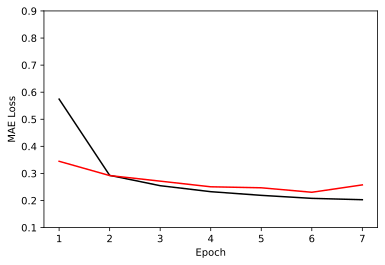

In [5]:

# Generate train/validate/test splits
RANDSTATE=42
np.random.seed(RANDSTATE)
tf.random.set_seed(RANDSTATE)
import os
os.environ['PYTHONHASHSEED']=str(RANDSTATE)
import random
random.seed(RANDSTATE)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

x_train, x_test,  y_train, y_test, f_train, f_test = \
  train_test_split(features, targets.reshape(-1, 1), jid, test_size=0.1,
                   random_state=RANDSTATE)
x_train, x_valid, y_train, y_valid, f_train, f_valid = \
  train_test_split(x_train, y_train, f_train, test_size=0.1,
                   random_state=RANDSTATE)
print ('XTRAIN SHAPE',x_train.shape, y_train.shape)
print("training    %s ~ %s"
      % ((x_train.shape), (y_train.shape)))
print("validation  %s ~ %s"
      % ((x_valid.shape), (y_valid.shape)))
print("testing     %s ~ %s"
      % ((x_test.shape), (y_test.shape)))


# Generate a feature and target scaler
feature_scaler = StandardScaler().fit(x_train)
target_scaler = StandardScaler().fit(y_train)

# Utilize that scaler on the datasets
x_train = feature_scaler.transform(x_train)
x_valid = feature_scaler.transform(x_valid)
x_test = feature_scaler.transform(x_test)
y_train = target_scaler.transform(y_train)
y_valid = target_scaler.transform(y_valid)
y_test = target_scaler.transform(y_test)




# Callbacks:
checkpoint_path = \
  'checkpoint.hdf5'
mcp_save = keras.callbacks.ModelCheckpoint(
    checkpoint_path, save_best_only=True, monitor='val_loss',
    mode='min')
reduce_lr_loss = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=10, verbose=1,
    min_delta=1e-4, mode='min', min_lr=1e-4)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
# Initialize a basic Keras model
def all_model(x_train, y_train, x_valid, y_valid,
              batch_size, epochs,
              verbose=0,
              loss='mae',
              optimizer='sgd',
              interior_activation='relu',
              dropout=0.0,
              layers=[1000, 700, 500, 300]):
  
  model = Sequential()
  
  model.add(Dense(layers[0], activation='relu',
                  input_shape=(x_train.shape[1],)))
  
  for ii in range(1, len(layers)):
    model.add(Dense(layers[ii], activation=interior_activation))
    model.add(Dropout(dropout))

  # This is a regression problem, won't want any activation on
  # the output layer
  model.add(Dense(y_train.shape[1], activation='linear'))

  model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])

  model.summary()
  
  history = model.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(x_valid, y_valid),
                      verbose=verbose,
                      callbacks=[es,mcp_save, reduce_lr_loss],
                      #callbacks=[mcp_save, reduce_lr_loss],
                      shuffle=True)

  return history, model




############################################################## Execute training

n_epochs = 160

# n_epochs = 10
opt = keras.optimizers.Adam()
history, model = all_model(
  x_train, y_train, x_valid, y_valid,
  epochs=n_epochs,
  verbose=1,
  #loss='logcosh',
  #loss='mean_squared_error',
  loss='mean_absolute_error',
  optimizer=opt,
  interior_activation='relu',
  batch_size=256,
  dropout=0.0,
  layers=[1557,900])
  #layers=[1557,900])#0.24
  #layers=[1557,500])

npt=len(history.history['loss'])
plt.plot(np.linspace(1, npt, npt), history.history['loss'], 'k')
plt.plot(np.linspace(1, npt, npt), history.history['val_loss'], 'r')
#plt.plot(np.linspace(1, n_epochs, n_epochs), np.array(history.history['lr'])*1000., 'b:')
plt.ylabel("MAE Loss")
plt.ylim([0.1,0.9])
plt.xlabel("Epoch")
plt.show()
  
model.load_weights(checkpoint_path)
predictions = model.predict(x_test)
y_test_original = target_scaler.inverse_transform(y_test)
y_predictions = target_scaler.inverse_transform(predictions)  